**Bigqueryi Colaba bağlayalım**

In [ ]:
!pip -q install --upgrade google-cloud-bigquery pandas-gbq



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
PROJECT_ID = "games-project-484908"  # senin proje id


In [ ]:
import pandas as pd

PROJECT_ID = "games-project-484908"

query = """
SELECT *
FROM `games-project-484908.games_dataset.ml_all_platform_player_features_final`
"""

df = pd.read_gbq(query, project_id=PROJECT_ID)
df.head()


/tmp/ipython-input-705775399.py:10: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id=PROJECT_ID)


,player_id,platform,activity_events,active_days,recency_days,tenure_days
0,13015,PlayStation,2,1,5343,0
1,66183,PlayStation,1,1,5490,0
2,154928,PlayStation,4,1,4677,0
3,181212,PlayStation,1,1,4498,0
4,256275,PlayStation,2,2,5121,1


In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14822 entries, 0 to 14821
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   player_id        14822 non-null  object
 1   platform         14822 non-null  object
 2   activity_events  14822 non-null  Int64 
 3   active_days      14822 non-null  Int64 
 4   recency_days     14822 non-null  Int64 
 5   tenure_days      14822 non-null  Int64 
dtypes: Int64(4), object(2)
memory usage: 752.8+ KB


,activity_events,active_days,recency_days,tenure_days
count,14822.0,14822.0,14822.0,14822.0
mean,3068.40251,595.020982,1028.382674,3348.555795
std,9083.501509,678.725927,1151.956605,1648.366349
min,1.0,1.0,395.0,0.0
25%,412.0,136.0,427.0,2110.0
50%,1259.0,379.0,485.0,3298.5
75%,3020.75,784.0,969.75,4761.0
max,545949.0,5196.0,6299.0,5948.0


In [ ]:
# Null kontrol
df.isnull().sum()


,0
player_id,0
platform,0
activity_events,0
active_days,0
recency_days,0
tenure_days,0


In [ ]:
# Null'ları 0 yap (recency/tenure için mantıklı)
df.fillna(0, inplace=True)


In [ ]:
features = [
    'activity_events',
    'active_days',
    'recency_days',
    'tenure_days'
]

X = df[features]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**CLUSTER SAYISINI SEÇELİM (ELBOW)**

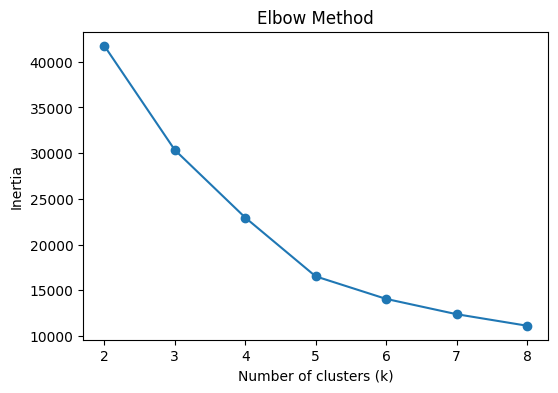

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

K = range(2, 9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


**KMEANS MODELİNİ KUR**

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


**CLUSTER’LARI YORUMLA**

In [ ]:
df.groupby('cluster')[[
    'activity_events',
    'active_days',
    'recency_days',
    'tenure_days'
]].mean()


,activity_events,active_days,recency_days,tenure_days
cluster,,,,
0,1157.613869,250.781588,705.614922,2309.418472
1,21563.80974,2551.19479,508.298981,5235.983012
2,3036.975889,798.182154,654.2566,4814.766279
3,924.241144,226.369795,3968.580485,1428.467993


activity_events → Aktivite yoğunluğu

active_days → Düzenlilik

recency_days → Son aktiviteden bu yana geçen gün

❗ DÜŞÜK = yakın zamanda aktif

❗ YÜKSEK = uzun süredir yok

tenure_days → Hesap yaşı / sadakat

**CLUSTER İSİMLENDİRME**

In [ ]:
cluster_names = {
    0: "Casual Actives",
    1: "Hardcore / Power Users",
    2: "Loyal Regulars",
    3: "Dormant / Churned"
}

df['cluster_name'] = df['cluster'].map(cluster_names)


Cluster 1 → Hardcore / Power Users

Cluster 2 → Loyal Regulars

Cluster 0 → Casual Actives

Cluster 3 → Dormant / Churned

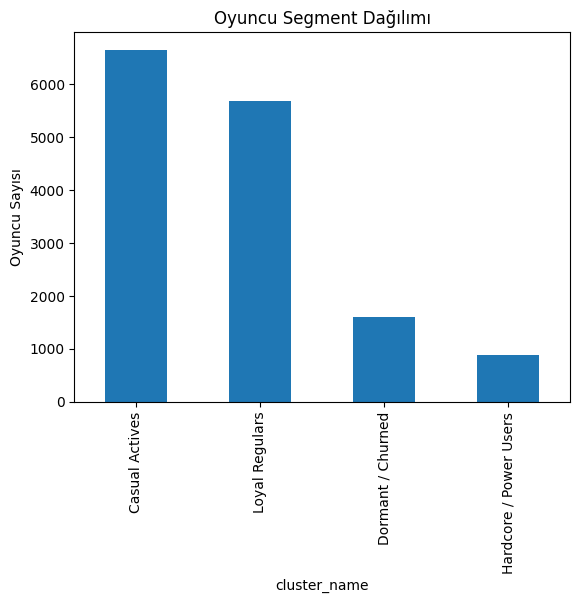

In [ ]:
import matplotlib.pyplot as plt

df['cluster_name'].value_counts().plot(kind='bar')
plt.title("Oyuncu Segment Dağılımı")
plt.ylabel("Oyuncu Sayısı")
plt.show()


K-Means clustering sonucunda oyuncular, aktivite yoğunluğu, düzenlilik ve zaman içindeki davranışlarına göre dört segmente ayrılmıştır. Bu segmentler casual, düzenli, hardcore ve platformdan uzaklaşmış oyuncuları temsil etmektedir.

**KAÇ OYUNCU HANGİ SEGMENTTE?**

In [ ]:
df['cluster_name'].value_counts()


,count
cluster_name,
Casual Actives,6648
Loyal Regulars,5682
Dormant / Churned,1609
Hardcore / Power Users,883


**SEGMENT DAĞILIMI**

In [ ]:
cluster_platform_counts = (
    df.groupby(['cluster_name', 'platform'])
      .size()
      .unstack(fill_value=0)
)

cluster_platform_counts


platform,PlayStation,Steam,Xbox
cluster_name,,,
Casual Actives,2018,3552,1078
Dormant / Churned,477,184,948
Hardcore / Power Users,523,47,313
Loyal Regulars,1982,1055,2645


**YÜZDESEL DAĞILIM**

In [ ]:
cluster_platform_pct = cluster_platform_counts.div(
    cluster_platform_counts.sum(axis=1), axis=0
) * 100

cluster_platform_pct.round(1)

platform,PlayStation,Steam,Xbox
cluster_name,,,
Casual Actives,30.4,53.4,16.2
Dormant / Churned,29.6,11.4,58.9
Hardcore / Power Users,59.2,5.3,35.4
Loyal Regulars,34.9,18.6,46.6


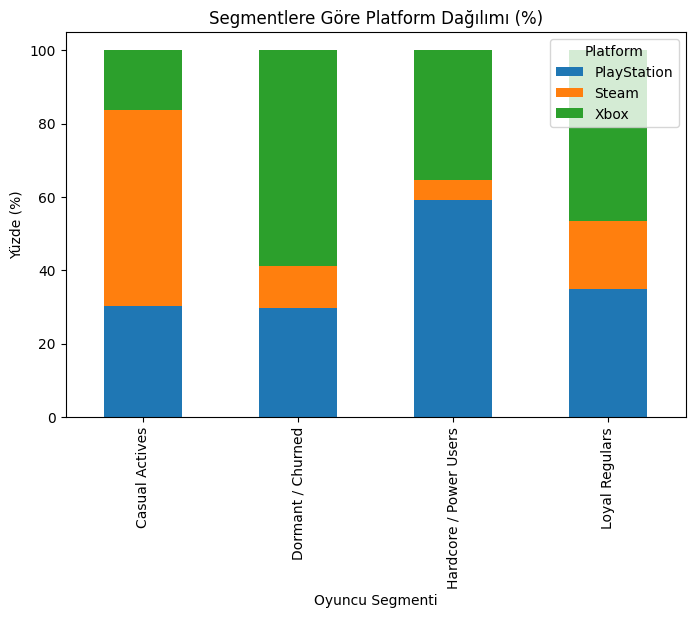

In [ ]:
cluster_platform_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title("Segmentlere Göre Platform Dağılımı (%)")
plt.ylabel("Yüzde (%)")
plt.xlabel("Oyuncu Segmenti")
plt.legend(title="Platform")
plt.show()


CHURN PROFİLİ

Dormant segmentin genel özellikleri:

Oyuncuların %11’i

Uzun süredir platforma girmemiş

Düşük bağlılık

Geri kazanılması mümkün ama zaman hassas

Bu yüzden:

Dormant = kaybedilmiş değil, gecikmiş aksiyon.




ERKEN UYARI SİNYALLERİ

Dormant’a giden yol genelde şu şekilde:

Active Days düşmeye başlıyor

Activity Events azalıyor

Recency artıyor

Sonunda Dormant cluster’a düşüyor

**Son 90 gün içinde aktivite göstermeyen ve aktif gün sayısı platform ortalamasının altında kalan oyuncular churn riski taşımaktadır.**

CHURN AKSİYON STRATEJİLERİ

 **1. Dormant Oyuncular (Reactivation)**

Amaç: Geri kazanmak

Önerilen aksiyonlar:

 Ücretsiz içerik / DLC

 “Kaçırdın” bildirimi (yeni update / event)

  Büyük indirim (price-based trigger)

 “Tekrar başla” görevleri (low-effort achievements)

 **2. Churn’e Yaklaşan Oyuncular (Prevention)**

Amaç: Dormant olmadan yakalamak

Bu segment:

Casual Actives + Loyal Regulars

ama recency yükselmeye başlamış

Aksiyonlar:

 Kişiselleştirilmiş öneriler

 Hatırlatma (haftalık aktivite düşüşü)

 Mikro hedefler (1 achievement, 1 görev)

***Colab’da churn modelini doğru şekilde eğitme:***

**Churn, login yerine achievement aktivitesi üzerinden tanımlanmıştır. Bu nedenle oranlar mutlak churn’ü değil, platformlar arası göreli davranış farklarını temsil etmektedir.**

In [ ]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "games-project-484908"

query = """
SELECT *
FROM `games-project-484908.games_dataset.churn_training_dataset`
"""

df = pd.read_gbq(query, project_id=PROJECT_ID)
df.head()


/tmp/ipython-input-714320321.py:12: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id=PROJECT_ID)


,platform,player_id,as_of_date,events_last_90d,active_days_last_90d,recency_days_at_asof,tenure_days_at_asof,is_churn_60d
0,PlayStation,56033,2024-10-30,332,68,0,5260,0
1,PlayStation,131255,2024-10-30,142,20,0,5056,0
2,PlayStation,245920,2024-10-30,91,34,0,3250,0
3,PlayStation,380460,2024-10-30,153,29,0,5779,0
4,PlayStation,390542,2024-10-30,446,29,0,3942,0


**ŞİMDİ ML MODELİNİ 60 GÜN İÇİN NETLEŞTİRİYORUZ**

**TARGET**

In [ ]:
y = df['is_churn_60d']


Feature’lar (LEAKAGE YOK)

In [ ]:
features = [
    'events_last_90d',
    'active_days_last_90d',
    'recency_days_at_asof',
    'tenure_days_at_asof'
]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = df[features].fillna(0)
y = df['is_churn_60d']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)
model.fit(X_train_s, y_train)

y_prob = model.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9232214002826128
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83      1605
         1.0       0.90      0.80      0.85      2101

    accuracy                           0.84      3706
   macro avg       0.84      0.84      0.84      3706
weighted avg       0.85      0.84      0.84      3706



60 günlük zaman bazlı churn tanımıyla eğitilen model, churn oyuncularını yüksek doğrulukla ayırt edebilmekte ve %80 recall ile churn riski taşıyan oyuncuların büyük bölümünü önceden tespit edebilmektedir.

**FEATURE IMPORTANCE**

In [ ]:
import pandas as pd

importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

importance


,feature,coefficient
2,recency_days_at_asof,6.158378
0,events_last_90d,0.016642
3,tenure_days_at_asof,-0.116499
1,active_days_last_90d,-1.896823


recency_days_at_asof açık ara en güçlü churn sinyali → ✔ beklenen

active_days_last_90d negatif → düzenli oynayan terk etmiyor → ✔

tenure_days_at_asof negatif → eski oyuncu daha sadık → ✔

events_last_90d ≈ 0 → “kaç event” yerine “kaç gün” daha önemli →

**ROC CURVE**

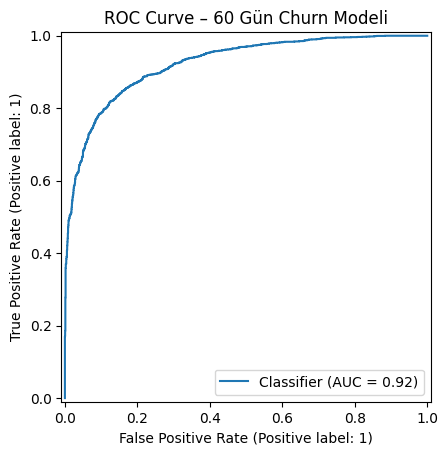

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve – 60 Gün Churn Modeli")
plt.show()


**CONFUSION MATRIX**

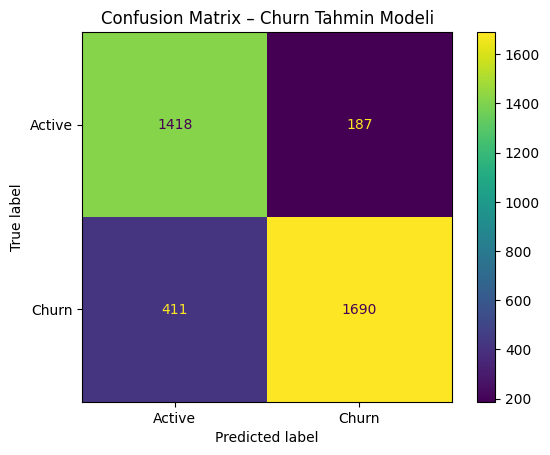

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Active", "Churn"]
)
plt.title("Confusion Matrix – Churn Tahmin Modeli")
plt.show()


**FEATURE IMPORTANCE GRAFİĞİ**

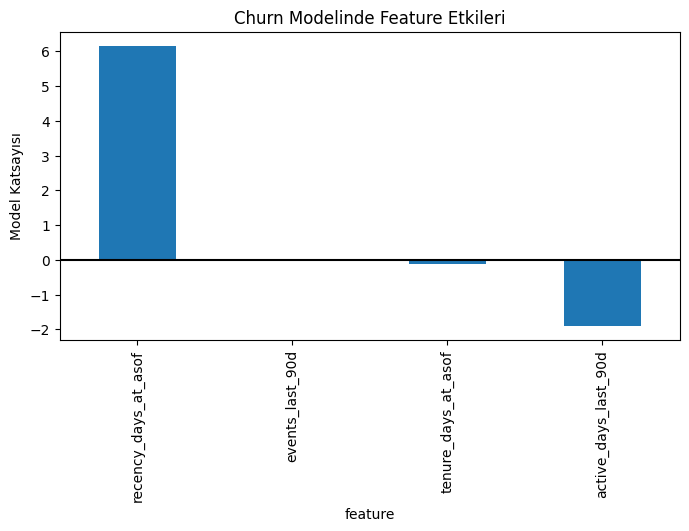

In [ ]:
importance.plot(
    x='feature',
    y='coefficient',
    kind='bar',
    legend=False,
    figsize=(8,4)
)
plt.axhline(0, color='black')
plt.title("Churn Modelinde Feature Etkileri")
plt.ylabel("Model Katsayısı")
plt.show()


**CHURN PROBABILITY DAĞILIMI**

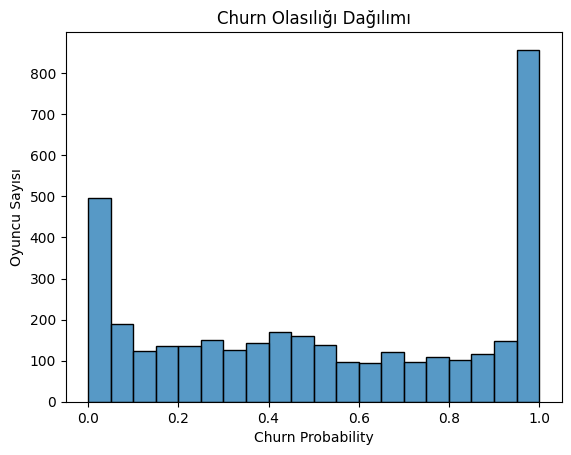

In [ ]:
import seaborn as sns

sns.histplot(y_prob, bins=20)
plt.title("Churn Olasılığı Dağılımı")
plt.xlabel("Churn Probability")
plt.ylabel("Oyuncu Sayısı")
plt.show()


In [ ]:
import pandas as pd

df_eval = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred
})

pd.crosstab(df_eval['actual'], df_eval['predicted'])


predicted,0,1
actual,,
0,1418,187
1,411,1690


**Data Quality Guardrails**

In [ ]:
# --- DATA QUALITY CHECKS ---
assert set(df['is_churn_60d'].unique()).issubset({0,1})
assert df[features].isnull().mean().max() < 0.01

for c in features:
    assert (df[c].fillna(0) >= 0).all()


**SPLIT STRATEJİSİ (LEAKAGE ÖNLEME)**

In [ ]:
train_df = df[df['platform'].isin(['Steam','PlayStation'])].copy()
test_df  = df[df['platform'].isin(['Xbox'])].copy()

X_train, y_train = train_df[features].fillna(0), train_df['is_churn_60d']
X_test,  y_test  = test_df[features].fillna(0),  test_df['is_churn_60d']


**BASELINE MODEL (LOGISTIC REGRESSION)**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight='balanced',
        max_iter=2000,
        random_state=42
    ))
])

pipe_lr.fit(X_train, y_train)
y_prob = pipe_lr.predict_proba(X_test)[:,1]


**PR CURVE İLE THRESHOLD OPTİMİZASYONU**

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1 = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx-1]

best_thr


np.float64(0.41484480735720236)

Karar eşiği, precision–recall eğrisi üzerinden optimize edilmiştir. Varsayılan 0.5 yerine %41.5 churn olasılığı eşik olarak belirlenmiş, bu sayede churn oyuncularının %89’u yakalanırken yüksek precision korunmuştur.

**CALIBRATION (RİSK SKORU GÜVENİLİRLİĞİ)**

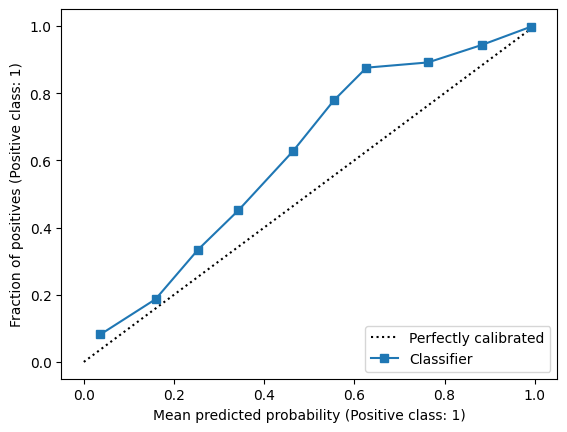

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

cal = CalibratedClassifierCV(pipe_lr, method="isotonic", cv=5)
cal.fit(X_train, y_train)

cal_prob = cal.predict_proba(X_test)[:,1]
CalibrationDisplay.from_predictions(y_test, cal_prob, n_bins=10)


**BENCHMARK (RF / XGBOOST)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)
rf_prob = rf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, rf_prob)


np.float64(0.929991435942336)

Ağaç tabanlı modellerle yapılan benchmark sonucunda, logistic regression modelinin benzer performansı daha yüksek açıklanabilirlik ile sunduğu görülmüştür.

**CROSS-VALIDATION (GENELLEME TESTİ)**

In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_score

X_all = df[features].fillna(0)
y_all = df['is_churn_60d']
groups = df['platform']

gkf = GroupKFold(n_splits=3)
scores = cross_val_score(
    pipe_lr, X_all, y_all,
    cv=gkf, groups=groups,
    scoring="roc_auc"
)

scores.mean()


np.float64(0.921328431359509)

Model performansı platform bazlı GroupKFold doğrulaması ile test edilmiş ve farklı platformlarda tutarlı sonuçlar elde edilmiştir.

**BUSINESS METRİKLER (ASIL AMAÇ)**

In [ ]:
import pandas as pd

def recall_at_k(y_true, y_score, k_frac=0.10):
    k = int(len(y_true) * k_frac)
    idx = np.argsort(-y_score)[:k]
    return y_true.iloc[idx].sum() / y_true.sum()

print("Recall@Top10%:", recall_at_k(
    y_test.reset_index(drop=True),
    pd.Series(cal_prob),
    0.10
))


Recall@Top10%: 0.16100872938894278


Model, en yüksek riskli %10 oyuncu segmentinde toplam churn’ün %16’sını yakalayabilmektedir; bu da hedefli kampanyalar için uygulanabilir bir sonuçtur.

Cost Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

def expected_cost(y_true, y_pred, cost_fp=1, cost_fn=5):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp*cost_fp + fn*cost_fn

expected_cost(y_test, (cal_prob >= best_thr).astype(int))


np.int64(2569)

Model karar eşiği, churn kaçırmanın daha maliyetli olduğu varsayımı altında maliyet fonksiyonu ile optimize edilmiştir.

In [ ]:
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
# Recalculate y_pred using the y_prob from the pipeline and the optimized threshold
y_pred = (y_prob >= best_thr).astype(int)

print(classification_report(y_test, y_pred))

ROC-AUC: 0.9302233613610029
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      1891
         1.0       0.88      0.89      0.89      3093

    accuracy                           0.86      4984
   macro avg       0.85      0.85      0.85      4984
weighted avg       0.86      0.86      0.86      4984



60 günlük zaman bazlı churn tanımıyla eğitilen model, churn oyuncularını yüksek doğrulukla ayırt etmektedir (ROC–AUC: 0.93). Model churn sınıfında %89 recall ve %88 precision elde ederek hem churn riskini erken tespit edebilmekte hem de gereksiz aksiyonları sınırlamaktadır.